In [156]:
#! conda install networkx -y

In [157]:
import numpy as np
import itertools
import math
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

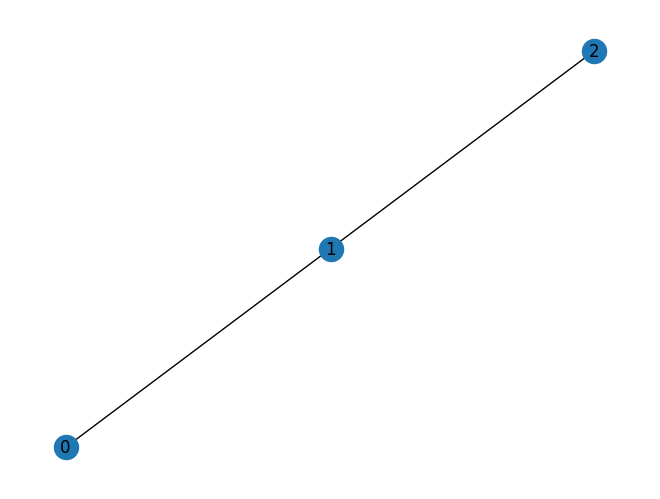

In [158]:
# Parameters
n = 3
epsilon = 1/(2*n)
graph_type = 'line' # 'random' or 'line' or 'complete'

# Randomness
gen = np.random.default_rng(0)

# Create a graph with n nodes
graph = nx.Graph()
graph.add_nodes_from(range(n))
if graph_type == 'complete':
    graph.add_edges_from(itertools.combinations(range(n), 2))
elif graph_type == 'line':
    graph.add_edges_from([(i, i+1) for i in range(n-1)])
elif graph_type == 'random':
    for i, j in itertools.combinations(range(n), 2):
        if gen.random() < 0.6: graph.add_edge(i, j)

# Visualize the graph
# Fix the positions of the nodes
nx.draw(graph, with_labels=True)

v_vector = gen.random(2**n)
v_vector -= v_vector[0]

## Utility Methods

In [159]:
def extract_singleton_from_vector(v_vector, n):
    single = np.zeros(n)
    for i in range(n):
        index = 2**i - 1
        single[i] = v_vector[index]
    return single

def convert_from_vector_to_dict(v_vector, n):
    v_dict = {}
    for idx in range(2**n):
        subset = tuple([j for j in range(n) if (idx >> j) & 1])
        v_dict[subset] = v_vector[idx]
    return v_dict

def extract_singleton_from_dict(v_dict, n):
    single = np.zeros(n)
    for i in range(n):
        single[i] = v_dict[tuple([i])]
    return single

def print_labelled_matrix(P, do_round=True):
    if do_round: P = P.round(3)
    df = pd.DataFrame(P)

    def subset_to_string(subset):
        return str([j for j in subset])

    for idx in range(2**n-1):
        subset = [j for j in range(n) if (idx + 1 >> j) & 1]
        df = df.rename(index={idx: subset_to_string(subset)})
        df = df.rename(columns={idx: subset_to_string(subset)})

    print(df)

## Computing Shapley Values

In [160]:
def compute_shapley_values_vector(n, v_vector):
    shap_values = np.zeros(n)
    for i in range(n):
        valid_items = [j for j in range(n) if j != i]
        for set_size in range(n):
            # Generate all subsets of size set_size
            weight = 1 / math.comb(n - 1, set_size)
            for subset in itertools.combinations(valid_items, set_size):
                # All indices from 0 to 2**n correspond to a subset
                # Convert from a subset to the associated index
                index_wo_i = sum([2**j for j in subset])
                index_w_i = index_wo_i + 2**i
                shap_values[i] += weight * (v_vector[index_w_i] - v_vector[index_wo_i])
    return shap_values / n

def compute_shapley_values_dict(n, v_dict):
    shap_values = np.zeros(n)
    for i in range(n):
        valid_items = [j for j in range(n) if j != i]
        for set_size in range(n):
            # Generate all subsets of size set_size
            weight = 1 / math.comb(n - 1, set_size)
            for subset in itertools.combinations(valid_items, set_size):
                subset = tuple(subset)
                subset_wo_i = subset
                subset_w_i = list(subset) + [i]
                subset_w_i.sort()
                subset_w_i = tuple(subset_w_i)
                shap_values[i] += weight * (v_dict[subset_w_i] - v_dict[subset_wo_i])
    return shap_values / n

## Shared Methods

In [161]:
def build_psi(n, epsilon):
    non_identity = np.zeros((2**n-1, 2**n-1))

    for row_idx in range(2**n-1):
        subset = [j for j in range(n) if (row_idx + 1 >> j) & 1]
        not_in_subset = [j for j in range(n) if j not in subset]
        non_identity[row_idx, row_idx] = -1 * len(not_in_subset)

        for j in not_in_subset:
           subset_with_j = subset + [j]
           subset_with_j.sort()
           subset_with_j_idx = sum([2**i for i in subset_with_j]) - 1
           non_identity[row_idx, subset_with_j_idx] = 1
           non_identity[row_idx, 2**j-1] = -1

    return np.eye(2**n-1) + epsilon * non_identity

def build_psi_graph(n, graph, epsilon):
    psi = np.zeros((2**n-1, 2**n-1))
    for row_idx in range(2**n-1):
        subset = [j for j in range(n) if (row_idx + 1 >> j) & 1]
        graph_subset = graph.subgraph(subset)
        for connected_component in nx.connected_components(graph_subset):
            nodes = list(connected_component)
            # Neighbors of nodes in the connected component
            neighbors = set()
            for node in nodes:
                neighbors |= set(graph.neighbors(node))
            neighbors -= set(nodes)
            nodes_idx = sum([2**i for i in nodes]) - 1
            psi[row_idx, nodes_idx] += 1 - epsilon * len(neighbors)

            for j in neighbors:
                nodes_w_j_idx = nodes_idx + 2**j
                psi[row_idx, nodes_w_j_idx] += epsilon
                psi[row_idx, 2**j-1] += -epsilon
    return psi

def build_proj_graph(n, graph):
    proj = np.zeros((2**n-1, 2**n-1))
    for row_idx in range(2**n-1):
        subset = [j for j in range(n) if (row_idx + 1 >> j) & 1]
        graph_subset = graph.subgraph(subset)
        for connected_component in nx.connected_components(graph_subset):
            nodes = list(connected_component)
            nodes_idx = sum([2**i for i in nodes]) - 1
            proj[row_idx, nodes_idx] = 1
    return proj

def compute_next_v_graph_dict(v, n, graph, epsilon):
    next_v = {}
    for idx in range(2**n):
        subset = tuple([j for j in range(n) if (idx >> j) & 1])
        graph_subset = graph.subgraph(subset)
        summation = 0
        for connected_component in nx.connected_components(graph_subset):
            nodes = list(connected_component)
            # Neighbors of nodes in the connected component
            neighbors = set()
            for node in nodes:
                neighbors |= set(graph.neighbors(node))
            neighbors -= set(nodes)
            summation += (1 - epsilon * len(neighbors)) * v[tuple(nodes)]
            for j in neighbors:
                nodes_w_j = list(nodes) + [j]
                nodes_w_j.sort()
                summation += epsilon * (v[tuple(nodes_w_j)] - v[tuple([j])])

        next_v[subset] = summation
    return next_v

def compute_next_v_dict(v, n, epsilon):
    next_v = {}
    for idx in range(2**n):
        subset = tuple([j for j in range(n) if (idx >> j) & 1])
        not_in_subset = [j for j in range(n) if j not in subset]
        summation = 0
        for j in not_in_subset:
            subset_with_j = list(subset) + [j]
            subset_with_j.sort()
            subset_with_j = tuple(subset_with_j)
            j = tuple([j])
            summation += v[subset_with_j] - v[j] - v[subset]

        next_v[subset] = v[subset] + epsilon * summation
    return next_v



## Computing Shapley Values

In [162]:
shap_values = compute_shapley_values_vector(n, v_vector)
print('Shapley values from vector:', shap_values)

Psi = build_psi(n, epsilon)
next_v = v_vector[1:]

for j in range(100):
    next_v = Psi @ next_v

print('Shapley values from matvec:', extract_singleton_from_vector(next_v, n))

next_Psi = Psi
for j in range(100):
    next_Psi = next_Psi @ Psi

print('Shapley values from matrix:', extract_singleton_from_vector(next_Psi @ v_vector[1:], n))

v_dict = convert_from_vector_to_dict(v_vector, n)

shap_values = compute_shapley_values_dict(n, v_dict)
print('Shapley values from dictio:', shap_values)

next_v = v_dict
for i in range(100):
    next_v = compute_next_v_dict(next_v, n, epsilon)

print('Shapley values from limitd:', extract_singleton_from_dict(next_v, n))

Shapley values from vector: [-0.06893149 -0.33639798  0.49786435]
Shapley values from matvec: [-0.06893149 -0.33639798  0.49786435]
Shapley values from matrix: [-0.06893149 -0.33639798  0.49786435]
Shapley values from dictio: [-0.06893149 -0.33639798  0.49786435]
Shapley values from limitd: [-0.06893149 -0.33639798  0.49786435]


## Speeding up Limit

In [ ]:
def build_unanimity_basis(n, is_inverse=False):
    P = np.zeros((2**n-1, 2**n-1))
    for idx in range(2**n-1):
        subset = [j for j in range(n) if (idx + 1 >> j) & 1]
        #print(subset)
        # for all supersets of subset
        remaining = [j for j in range(n) if j not in subset]
        for length in range(len(remaining)+1):
            for new_subset in itertools.combinations(remaining, length):
                new_subset = subset + list(new_subset)
                new_subset_idx = sum([2**i for i in new_subset]) -1
                P[new_subset_idx, idx] = 1
                if is_inverse:
                    if len(new_subset) % 2 != len(subset) % 2 and len(new_subset) > len(subset):
                        P[new_subset_idx, idx] = -1
    return P

def build_triangular(n, epsilon):
    triangular = np.zeros((2**n-1, 2**n-1))
    for idx in range(2**n-1):
        subset = [j for j in range(n) if (idx + 1 >> j) & 1]
        if len(subset) == 1:
            triangular[idx,idx] = 1
        else:
            triangular[idx,idx] = 1 - epsilon * len(subset)
            for i in subset:
                triangular[idx - 2**i, idx] = epsilon
    return triangular

def build_triangular_graph(n, graph, epsilon):
    triangular = np.zeros((2**n-1, 2**n-1))
    for idx in range(2**n-1):
        subset = [j for j in range(n) if (idx + 1 >> j) & 1] 
        if len(subset) == 1:
            triangular[idx,idx] = 1 
            continue
        graph_subset = graph.subgraph(subset)
        #if nx.is_connected(graph_subset):
        for connected_component in nx.connected_components(graph_subset):
            nodes = list(connected_component)
            # Neighbors of nodes in the connected component
            neighbors = set()
            for node in nodes:
                neighbors |= set(graph.neighbors(node))
            neighbors -= set(nodes)
            nodes_idx = sum([2**i for i in nodes]) - 1
            triangular[nodes_idx, idx] += 1- epsilon * len(neighbors)
            for i in neighbors:
                triangular[nodes_idx - 2**i, idx] += epsilon
    return triangular

def build_tri_limit(n):
    tri = np.zeros((2**n-1, 2**n-1))
    for j in range(n):
        row_idx = 2**j - 1
        valid_items = [i for i in range(n) if j != i]
        for set_size in range(n):
            for subset in itertools.combinations(valid_items, set_size):
                col_idx = sum([2**i for i in subset]) - 1 + 2**j
                tri[row_idx, col_idx] = 1/(set_size+1)
    return tri

## HN Values

In [164]:
unanimity = build_unanimity_basis(n)
unanimity_inv = build_unanimity_basis(n, is_inverse=True)
Psi = build_psi_graph(n, graph, epsilon)
print('Triangular graph matrix:')
print_labelled_matrix((unanimity_inv @ Psi @ unanimity).round(3))

triangular = build_triangular(n, epsilon)
print('Triangular matrix:')
print_labelled_matrix(triangular)
next_v = v_vector[1:]

for j in range(50):
    next_v = Psi @ next_v

print('HamNava values from matvec:', extract_singleton_from_vector(next_v, n))

next_Psi = Psi
for j in range(60):
    next_Psi = next_Psi @ Psi

print('HamNava values from matrix:', extract_singleton_from_vector(next_Psi @ v_vector[1:], n))

v_dict = convert_from_vector_to_dict(v_vector, n)

next_v = v_dict
for i in range(100):
    next_v = compute_next_v_graph_dict(next_v, n, graph, epsilon)

print('HamNava values from limitd:', extract_singleton_from_dict(next_v, n))


triangular = build_triangular_graph(n, graph, epsilon)
empirical_limit = triangular
for j in range(10):
    empirical_limit = empirical_limit @ empirical_limit

limiting_vec = unanimity @ empirical_limit @ unanimity_inv @ v_vector[1:]
print('HamNava values from shorte:', extract_singleton_from_vector(limiting_vec, n))

Triangular graph matrix:
           [0]  [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]
[0]        1.0  0.0   0.167  0.0   0.000   0.000      0.000
[1]        0.0  1.0   0.167  0.0   0.000   0.167      0.000
[0, 1]    -0.0 -0.0   0.667  0.0   0.167   0.000      0.167
[2]        0.0  0.0   0.000  1.0   0.000   0.167      0.000
[0, 2]     0.0  0.0   0.000  0.0   0.000   0.000      0.000
[1, 2]     0.0 -0.0   0.000 -0.0   0.167   0.667      0.167
[0, 1, 2]  0.0  0.0   0.000  0.0   0.667   0.000      0.667
Triangular matrix:
           [0]  [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]
[0]        1.0  0.0   0.167  0.0   0.167   0.000      0.000
[1]        0.0  1.0   0.167  0.0   0.000   0.167      0.000
[0, 1]     0.0  0.0   0.667  0.0   0.000   0.000      0.167
[2]        0.0  0.0   0.000  1.0   0.167   0.167      0.000
[0, 2]     0.0  0.0   0.000  0.0   0.667   0.000      0.167
[1, 2]     0.0  0.0   0.000  0.0   0.000   0.667      0.167
[0, 1, 2]  0.0  0.0   0.000  0.0   0.000   0.000      0.

In [165]:
print_labelled_matrix(next_Psi.round(3))

           [0]   [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]
[0]        0.5 -0.25    0.25  0.0     0.0   -0.25       0.25
[1]       -0.5  0.50    0.00 -0.5     0.0    0.00       0.50
[0, 1]    -0.0  0.25    0.25 -0.5     0.0   -0.25       0.75
[2]        0.0 -0.25   -0.25  0.5     0.0    0.25       0.25
[0, 2]     0.5 -0.50    0.00  0.5     0.0    0.00       0.50
[1, 2]    -0.5  0.25   -0.25 -0.0     0.0    0.25       0.75
[0, 1, 2]  0.0  0.00    0.00  0.0     0.0    0.00       1.00


In [201]:
P = build_unanimity_basis(n, is_inverse=False)
P_inv = build_unanimity_basis(n, is_inverse=True)
proj = build_proj_graph(n,graph)
tri = build_triangular(n, epsilon)

print_labelled_matrix(proj @ P @ tri @ P_inv @ proj)

             [0]    [1]  [0, 1]    [2]  [0, 2]  [1, 2]  [0, 1, 2]
[0]        0.833 -0.167   0.167  0.000     0.0   0.000      0.000
[1]       -0.167  0.667   0.167 -0.167     0.0   0.167      0.000
[0, 1]     0.000  0.000   0.833 -0.167     0.0   0.000      0.167
[2]        0.000 -0.167   0.000  0.833     0.0   0.167      0.000
[0, 2]     0.833 -0.333   0.167  0.833     0.0   0.167      0.000
[1, 2]    -0.167  0.000   0.000  0.000     0.0   0.833      0.167
[0, 1, 2]  0.000  0.000   0.000  0.000     0.0   0.000      1.000


In [ ]:
psi_wo_graph = build_psi(n, epsilon)

psi_w_graph = build_psi_graph(n, graph, epsilon)

proj = build_proj_graph(n, graph)



def power_up(matrix, iterations):
    powered = matrix.copy()
    for i in range(iterations):
        powered = powered @ matrix
    return powered

iterations = 50
print_labelled_matrix(power_up(psi_wo_graph, iterations))
print_labelled_matrix(power_up(psi_w_graph, iterations))
print_labelled_matrix(proj @ power_up(psi_wo_graph @ proj, iterations))

             [0]    [1]  [0, 1]    [2]  [0, 2]  [1, 2]  [0, 1, 2]
[0]        0.333 -0.167   0.167 -0.167   0.167  -0.333      0.333
[1]       -0.167  0.333   0.167 -0.167  -0.333   0.167      0.333
[0, 1]     0.167  0.167   0.333 -0.333  -0.167  -0.167      0.667
[2]       -0.167 -0.167  -0.333  0.333   0.167   0.167      0.333
[0, 2]     0.167 -0.333  -0.167  0.167   0.333  -0.167      0.667
[1, 2]    -0.333  0.167  -0.167  0.167  -0.167   0.333      0.667
[0, 1, 2]  0.000  0.000   0.000  0.000   0.000   0.000      1.000
           [0]   [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]
[0]        0.5 -0.25    0.25  0.0     0.0   -0.25       0.25
[1]       -0.5  0.50    0.00 -0.5     0.0    0.00       0.50
[0, 1]    -0.0  0.25    0.25 -0.5     0.0   -0.25       0.75
[2]        0.0 -0.25   -0.25  0.5     0.0    0.25       0.25
[0, 2]     0.5 -0.50    0.00  0.5     0.0    0.00       0.50
[1, 2]    -0.5  0.25   -0.25 -0.0     0.0    0.25       0.75
[0, 1, 2]  0.0  0.00    0.00  0.0     0.0    

In [180]:
print(psi_wo_graph.round(3))

print(psi_w_graph.round(3))

print((psi_wo_graph @ proj).round(3))

assert np.allclose(proj @ (psi_wo_graph @ proj), psi_w_graph)

[[ 0.667 -0.167  0.167 -0.167  0.167  0.     0.   ]
 [-0.167  0.667  0.167 -0.167  0.     0.167  0.   ]
 [ 0.     0.     0.833 -0.167  0.     0.     0.167]
 [-0.167 -0.167  0.     0.667  0.167  0.167  0.   ]
 [ 0.    -0.167  0.     0.     0.833  0.     0.167]
 [-0.167  0.     0.     0.     0.     0.833  0.167]
 [ 0.     0.     0.     0.     0.     0.     1.   ]]
[[ 0.833 -0.167  0.167  0.     0.     0.     0.   ]
 [-0.167  0.667  0.167 -0.167  0.     0.167  0.   ]
 [ 0.     0.     0.833 -0.167  0.     0.     0.167]
 [ 0.    -0.167  0.     0.833  0.     0.167  0.   ]
 [ 0.833 -0.333  0.167  0.833  0.     0.167  0.   ]
 [-0.167  0.     0.     0.     0.     0.833  0.167]
 [ 0.     0.     0.     0.     0.     0.     1.   ]]
[[ 0.833 -0.167  0.167  0.     0.     0.     0.   ]
 [-0.167  0.667  0.167 -0.167  0.     0.167  0.   ]
 [ 0.     0.     0.833 -0.167  0.     0.     0.167]
 [ 0.    -0.167  0.     0.833  0.     0.167  0.   ]
 [ 0.833 -0.167  0.     0.833  0.     0.     0.167]
 [-0.167  

In [168]:
unanimity = build_unanimity_basis(n)
unanimity_inv = build_unanimity_basis(n, is_inverse=True)
Psi = build_psi_graph(n, graph, epsilon)
tri_psi = unanimity_inv @ Psi @ unanimity
#print('Triangular graph matrix:')
#print_labelled_matrix((unanimity_inv @ Psi @ unanimity).round(3))

triangular = build_triangular(n, epsilon)
#print('Triangular matrix:')
#print_labelled_matrix(triangular)

# Limiting matrices

tri_limit = tri_psi
for j in range(20):
    tri_limit = tri_limit @ tri_limit
print('Triangular limit matrix:')
print_labelled_matrix(tri_limit.round(3))
print('sum of columns:', tri_limit.sum(axis=0))

tri_limit_complete = build_triangular(n, epsilon)
for j in range(20):
    tri_limit_complete = tri_limit_complete @ tri_limit_complete
print('Triangular limit complete matrix:')
print_labelled_matrix(tri_limit_complete.round(3))
print('sum of columns:', tri_limit_complete.sum(axis=0))

Triangular limit matrix:
           [0]  [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]
[0]        1.0 -0.0     0.5  0.0    0.25    -0.0       0.25
[1]        0.0  1.0     0.5 -0.0    0.50     0.5       0.50
[0, 1]    -0.0 -0.0    -0.0  0.0   -0.00    -0.0      -0.00
[2]        0.0 -0.0     0.0  1.0    0.25     0.5       0.25
[0, 2]     0.0  0.0     0.0  0.0    0.00     0.0       0.00
[1, 2]     0.0 -0.0     0.0 -0.0   -0.00    -0.0      -0.00
[0, 1, 2]  0.0  0.0     0.0 -0.0    0.00     0.0       0.00
sum of columns: [1. 1. 1. 1. 1. 1. 1.]
Triangular limit complete matrix:
           [0]  [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]
[0]        1.0  0.0     0.5  0.0     0.5     0.0      0.333
[1]        0.0  1.0     0.5  0.0     0.0     0.5      0.333
[0, 1]     0.0  0.0     0.0  0.0     0.0     0.0      0.000
[2]        0.0  0.0     0.0  1.0     0.5     0.5      0.333
[0, 2]     0.0  0.0     0.0  0.0     0.0     0.0      0.000
[1, 2]     0.0  0.0     0.0  0.0     0.0     0.0      0.000
[0

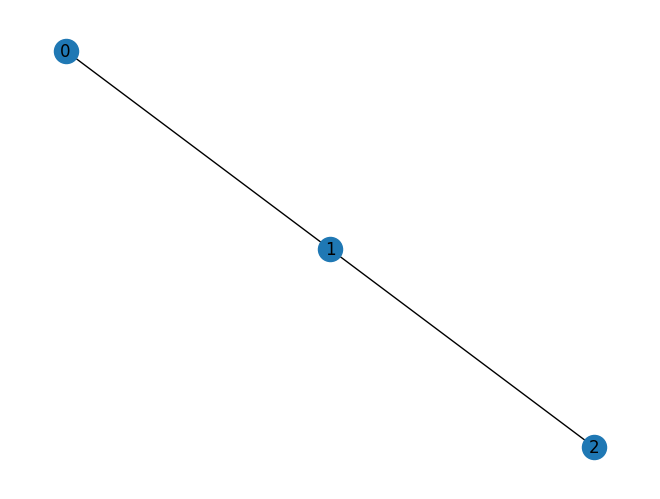

In [169]:
nx.draw(graph, with_labels=True)

## Matrix in the Limit

In [170]:
def build_short_matrix(n):
    short = np.zeros((n, 2**n-1))
    for j in range(n):
        valid_items = [i for i in range(n) if j != i]
        for idx in range(2**n-1):
            subset = [i for i in range(n) if (idx + 1 >> i) & 1]
            size = len(subset)
            size_w_j = size + 1 if j not in subset else size
            #value = 0
            #for ell in range(size_w_j, n+1):
            #    value += 1/ell * (-1) ** (ell - size) \
            #        * math.comb(n - size_w_j, ell - size_w_j)
            value = -1/(math.comb(n-1, size) *n) if j not in subset else 1/(math.comb(n-1, size-1) *n)
            short[j, idx] = value
    return short

analytical_norm = []
for idx in range(2**n-1):
    subset = [i for i in range(n) if (idx+1>>i) & 1]
    s = len(subset)
    if s < n:
        l2_norm = 1 / n * 1 / math.comb(n, s) * (1 / math.comb(n-1, s-1) + 1/ math.comb(n-1, s))
    else:
        l2_norm = 1/n
    analytical_norm.append(l2_norm)

short = build_short_matrix(n)

print(np.array(analytical_norm))

print(np.linalg.norm(short, axis=0)**2)

print_labelled_matrix(short)


short @ v_vector[1:]

[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.33333333]
[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667
 0.33333333]
          [0]    [1]  [0, 1]    [2]  [0, 2]  [1, 2]  [0, 1, 2]
[0]     0.333 -0.167   0.167 -0.167   0.167  -0.333      0.333
[1]    -0.167  0.333   0.167 -0.167  -0.333   0.167      0.333
[0, 1] -0.167 -0.167  -0.333  0.333   0.167   0.167      0.333


array([-0.06893149, -0.33639798,  0.49786435])

In [192]:



triangular = build_triangular(n, epsilon)

print_labelled_matrix(triangular)

#triangular = build_triangular_graph(n, graph, epsilon)

print_labelled_matrix(triangular)

empirical_tri_limit = np.linalg.matrix_power(triangular, 1000)

P = build_unanimity_basis(n)
P_inv = build_unanimity_basis(n, is_inverse=True)

tri_limit = build_tri_limit(n)

tri_limit = empirical_tri_limit

print_labelled_matrix(tri_limit)

result = P @ (tri_limit @ (P_inv @ v_vector[1:]))

print(extract_singleton_from_vector(result,n))


           [0]  [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]
[0]        1.0  0.0   0.167  0.0   0.167   0.000      0.000
[1]        0.0  1.0   0.167  0.0   0.000   0.167      0.000
[0, 1]     0.0  0.0   0.667  0.0   0.000   0.000      0.167
[2]        0.0  0.0   0.000  1.0   0.167   0.167      0.000
[0, 2]     0.0  0.0   0.000  0.0   0.667   0.000      0.167
[1, 2]     0.0  0.0   0.000  0.0   0.000   0.667      0.167
[0, 1, 2]  0.0  0.0   0.000  0.0   0.000   0.000      0.500
           [0]  [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]
[0]        1.0  0.0   0.167  0.0   0.167   0.000      0.000
[1]        0.0  1.0   0.167  0.0   0.000   0.167      0.000
[0, 1]     0.0  0.0   0.667  0.0   0.000   0.000      0.167
[2]        0.0  0.0   0.000  1.0   0.167   0.167      0.000
[0, 2]     0.0  0.0   0.000  0.0   0.667   0.000      0.167
[1, 2]     0.0  0.0   0.000  0.0   0.000   0.667      0.167
[0, 1, 2]  0.0  0.0   0.000  0.0   0.000   0.000      0.500
           [0]  [1]  [0, 1]  [2]  [0, 2]

In [172]:
print_labelled_matrix(build_tri_limit(n).round(2))

           [0]  [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]
[0]        1.0  0.0     0.5  0.0     0.5     0.0       0.33
[1]        0.0  1.0     0.5  0.0     0.0     0.5       0.33
[0, 1]     0.0  0.0     0.0  0.0     0.0     0.0       0.00
[2]        0.0  0.0     0.0  1.0     0.5     0.5       0.33
[0, 2]     0.0  0.0     0.0  0.0     0.0     0.0       0.00
[1, 2]     0.0  0.0     0.0  0.0     0.0     0.0       0.00
[0, 1, 2]  0.0  0.0     0.0  0.0     0.0     0.0       0.00


In [173]:
print_labelled_matrix(empirical_tri_limit.round(2))

           [0]  [1]  [0, 1]  [2]  [0, 2]  [1, 2]  [0, 1, 2]
[0]        1.0  0.0     1.0  0.0     1.0     1.0        0.0
[1]        0.0  1.0     0.2  0.0     0.2     0.2        0.0
[0, 1]     0.0  0.0     0.0  0.0     0.0     0.0        0.0
[2]        0.0  0.0     1.0  1.0     1.0     1.0        0.0
[0, 2]     0.0  0.0     0.0  0.0     0.0     0.0        0.0
[1, 2]     0.0  0.0     0.0  0.0     0.0     0.0        0.0
[0, 1, 2]  0.0  0.0     0.0  0.0     0.0     0.0        1.0
